In [96]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [97]:
def calculate_var_covar_pandas(data):
    
    # Calculate covariance matrix
    covar_matrix = data.cov()
    
    # Extract variances (diagonal elements)
    variances = np.diag(covar_matrix)
    
    return covar_matrix, variances

# Visualization function
def plot_covariance_matrix(covar_matrix, instrument_names=None):
    """
    Plot heatmap of covariance matrix
    """
    plt.figure(figsize=(5, 4))
    
    if instrument_names is None:
        instrument_names = [f'Instrument_{i+1}' for i in range(covar_matrix.shape[0])]
    
    sns.heatmap(covar_matrix, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                xticklabels=instrument_names,
                yticklabels=instrument_names,
                fmt='.4f')
    
    plt.title('Variance-Covariance Matrix')
    plt.tight_layout()
    plt.show()

In [138]:
file_path = os.getcwd() + '/data/fund.xlsx'
data = pd.read_excel(file_path, sheet_name='time_series', index_col=0)
fund_data = pd.read_excel(file_path, sheet_name='fund_new', index_col=0)


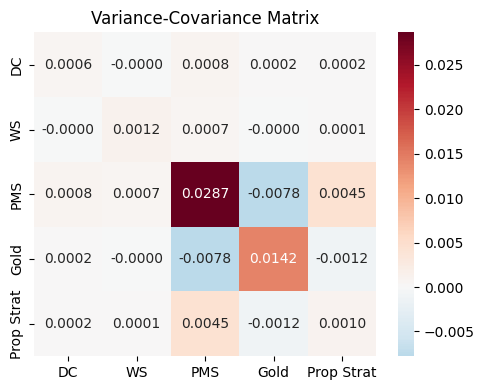

In [146]:
covariance_matrix, variances = calculate_var_covar_pandas(data)
annual_covar_matrix = covariance_matrix * 12  # Annualize the covariance matrix
plot_covariance_matrix(annual_covar_matrix, instrument_names=data.columns)

In [ ]:
num_assets = covariance_matrix.shape[0]
expected_returns = fund_data['Net Return'].values
covar_matrix = covariance_matrix.values  # Convert to numpy array

annual_covar_matrix = covar_matrix * 12  # Annualize covariance matrix

# Initializing the weights variable
weights = cp.Variable(num_assets)

# Calculate the portfolio volatility
portfolio_variance = cp.quad_form(weights, annual_covar_matrix)
portfolio_vol = cp.sqrt(portfolio_variance)
risk_tolerance = 0.06 # risk tolerance level
risk_tolerance_variance = risk_tolerance ** 2

# Define the objective function
objective = cp.Maximize(expected_returns @ weights)

# Define the constraints
constraints = [
    cp.sum(weights) == 1,
    weights >= 0,
    portfolio_variance <= risk_tolerance_variance, # Risk tolerance constraint
]

# Formulate the problem
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Check if the problem was solved successfully
print("Problem Status:", problem.status)
print("Optimal Value (Maximum Expected Return):", problem.value)
annual_expected_returns = expected_returns  # Annualize expected returns
# Extract the optimal weights
if problem.status == cp.OPTIMAL:
    optimal_weights = weights.value
    print("\nOptimal Portfolio Weights:")
    for i, weight in enumerate(optimal_weights):
        print(f"Asset {i}: {weight:.4f} ({weight*100:.2f}%)")
    
    # Calculate portfolio metrics using annualized data
    portfolio_return = annual_expected_returns.T @ optimal_weights
    portfolio_risk = np.sqrt(optimal_weights.T @ annual_covar_matrix @ optimal_weights)
    
    print(f"\nAnnualized Portfolio Metrics:")
    print(f"Expected Return: {portfolio_return:.4f} ({portfolio_return*100:.2f}%)")
    print(f"Portfolio Risk (Volatility): {portfolio_risk:.4f} ({portfolio_risk*100:.2f}%)")
    
    # Calculate risk contributions using annualized covariance matrix
    marginal_risk_contribs = (annual_covar_matrix @ optimal_weights) / portfolio_risk
    risk_contributions = optimal_weights * marginal_risk_contribs
    
    print(f"\nRisk Contributions:")
    for i, risk_contrib in enumerate(risk_contributions):
        percentage = (risk_contrib / portfolio_risk) * 100
        print(f"Asset {i}: {risk_contrib:.4f} ({percentage:.2f}% of total risk)")
    
    # Verify constraints
    print(f"\nConstraint Verification:")
    print(f"Weights sum to 1: {np.sum(optimal_weights):.4f}")
    print(f"Portfolio risk <= tolerance: {portfolio_risk:.4f} <= {risk_tolerance}")
    print(f"All weights >= 0: {np.all(optimal_weights >= -1e-6)}")  # Small tolerance for numerical errors
    
else:
    print("Optimization failed!")
    print("Status:", problem.status)
    if problem.status == cp.INFEASIBLE:
        print("The problem is infeasible - constraints cannot be satisfied")
    elif problem.status == cp.UNBOUNDED:
        print("The problem is unbounded")


Problem Status: optimal
Optimal Value (Maximum Expected Return): 0.17708312522869132

Optimal Portfolio Weights:
Asset 0: 0.1864 (18.64%)
Asset 1: 0.0915 (9.15%)
Asset 2: 0.3443 (34.43%)
Asset 3: 0.3779 (37.79%)
Asset 4: 0.0000 (0.00%)

Annualized Portfolio Metrics:
Expected Return: 0.1771 (17.71%)
Portfolio Risk (Volatility): 0.0600 (6.00%)

Risk Contributions:
Asset 0: 0.0014 (2.40% of total risk)
Asset 1: 0.0005 (0.85% of total risk)
Asset 2: 0.0410 (68.35% of total risk)
Asset 3: 0.0170 (28.40% of total risk)
Asset 4: 0.0000 (0.00% of total risk)

Constraint Verification:
Weights sum to 1: 1.0000
Portfolio risk <= tolerance: 0.0600 <= 0.06
All weights >= 0: True


In [ ]:
import cvxpy as cp
import numpy as np

def optimize_portfolio_with_risk_cap(expected_returns, covariance_matrix, 
                                     risk_tolerance=0.06, 
                                     max_risk_contrib=0.40, 
                                     min_weight=0.1, max_weight=1.0, 
                                     verbose=False):

    num_assets = len(expected_returns)
    risk_tolerance_variance = risk_tolerance ** 2
    
    # Initial equal bounds
    weight_bounds = [(min_weight, max_weight)] * num_assets
    

    while True:
        # Define optimization problem
        weights = cp.Variable(num_assets)
        portfolio_variance = cp.quad_form(weights, covariance_matrix)
        portfolio_vol = cp.sqrt(portfolio_variance)

        objective = cp.Maximize(expected_returns @ weights)

        # Update constraints with new bounds
        min_weight_arr = np.array([b[0] for b in weight_bounds])
        max_weight_arr = np.array([b[1] for b in weight_bounds])

        constraints = [
            cp.sum(weights) == 1,
            weights >= min_weight_arr,
            weights <= max_weight_arr,
            portfolio_variance <= risk_tolerance_variance
        ]
        
        problem = cp.Problem(objective, constraints)
        problem.solve()

        if problem.status != cp.OPTIMAL:
            return {"status": problem.status, "message": "Optimization failed"}

        optimal_weights = weights.value
        portfolio_return = expected_returns.T @ optimal_weights
        portfolio_risk = np.sqrt(optimal_weights.T @ covariance_matrix @ optimal_weights)

        # Compute marginal & total risk contributions
        marginal_risk_contribs = (covariance_matrix @ optimal_weights) / portfolio_risk
        risk_contributions = optimal_weights * marginal_risk_contribs
        risk_contrib_perc = risk_contributions / portfolio_risk

        if verbose:
            print("\nIteration Results:")
            for i in range(num_assets):
                print(f"Asset {i}: Weight={optimal_weights[i]:.4f}, "
                      f"Risk Contribution={risk_contrib_perc[i]*100:.2f}%")

        # Check stopping condition
        if np.all(risk_contrib_perc <= max_risk_contrib + 1e-6):
            break

        # Adjust max_weight for assets breaching risk cap
        for i in range(num_assets):
            if risk_contrib_perc[i] > max_risk_contrib:
                # tighten the cap for this asset
                weight_bounds[i] = (min_weight, min(weight_bounds[i][1], optimal_weights[i]*0.9))

    return {
        "status": problem.status,
        "weights": optimal_weights,
        "expected_return": portfolio_return,
        "risk": portfolio_risk,
        "risk_contributions": risk_contrib_perc,
    }


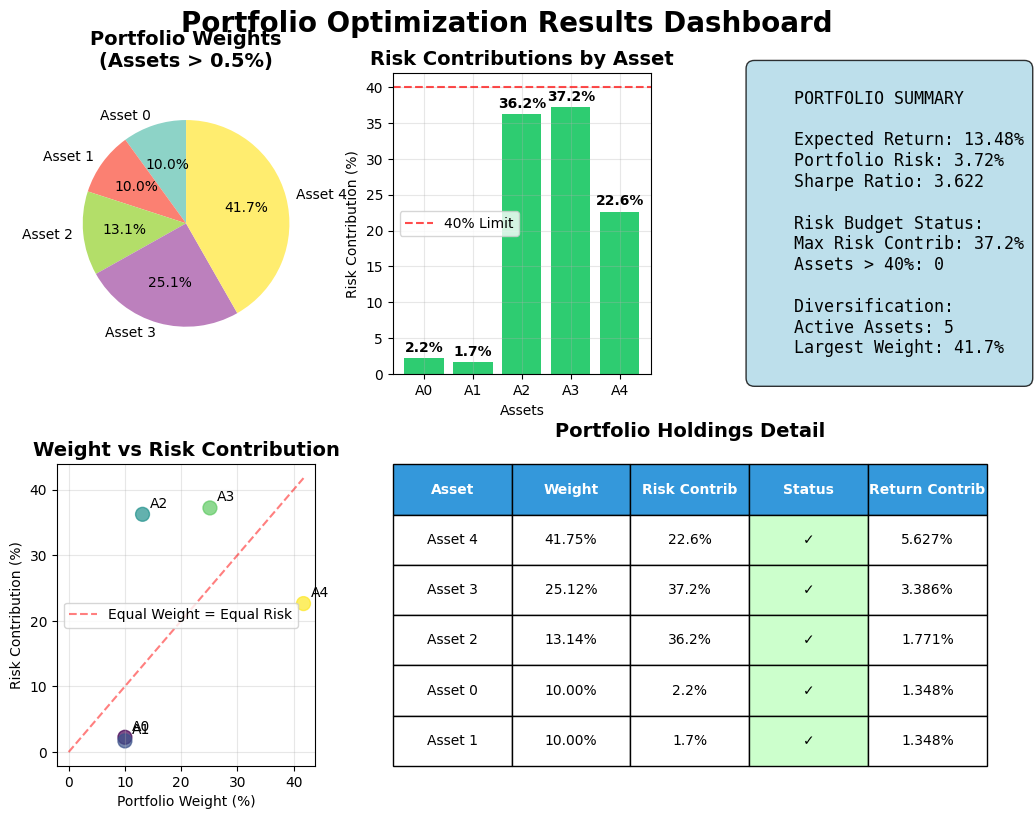

PORTFOLIO OPTIMIZATION SUMMARY
Expected Annual Return: 13.48%
Annual Risk (Volatility): 3.72%
Risk-Adjusted Return: 3.622
Number of Holdings: 5
Largest Position: 41.7%
Risk Budget Violations: 0 assets


In [142]:
results = optimize_portfolio_with_risk_cap(
    expected_returns=annual_expected_returns,
    covariance_matrix=annual_covar_matrix,
    risk_tolerance=0.06,
    max_risk_contrib=0.40,
    verbose=False
)

visualize_portfolio_results(results)


In [131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

def visualize_portfolio_results(results):
    """
    Create a comprehensive visual dashboard for portfolio optimization results
    
    Parameters:
    results: dict containing 'weights', 'expected_return', 'risk', 'risk_contributions'
    """
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(12, 9))
    fig.suptitle('Portfolio Optimization Results Dashboard', 
                fontsize=20, fontweight='bold', y=0.95)
    
    # Create a grid layout (2x3 since we removed the bottom row)
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1], 
                         hspace=0.3, wspace=0.3)
    
    # Extract data
    weights = results["weights"]
    expected_return = results["expected_return"]
    portfolio_risk = results["risk"]
    risk_contributions = results["risk_contributions"] * 100  # Convert to percentage
    
    # Create asset labels
    asset_labels = [f'Asset {i}' for i in range(len(weights))]
    
    # 1. Portfolio Weights Pie Chart
    ax1 = fig.add_subplot(gs[0, 0])
    # Only show assets with weight > 0.5%
    significant_weights = weights > 0.005
    plot_weights = weights[significant_weights]
    plot_labels = [asset_labels[i] for i in range(len(weights)) if significant_weights[i]]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(plot_weights)))
    wedges, texts, autotexts = ax1.pie(plot_weights, labels=plot_labels, autopct='%1.1f%%',
                                      colors=colors, startangle=90)
    ax1.set_title('Portfolio Weights\n(Assets > 0.5%)', fontsize=14, fontweight='bold', pad=20)
    
    # 2. Risk Contributions Bar Chart
    ax2 = fig.add_subplot(gs[0, 1])
    bars = ax2.bar(range(len(risk_contributions)), risk_contributions, 
                   color=['#e74c3c' if x > 40 else '#2ecc71' for x in risk_contributions])
    ax2.axhline(y=40, color='red', linestyle='--', alpha=0.7, label='40% Limit')
    ax2.set_xlabel('Assets')
    ax2.set_ylabel('Risk Contribution (%)')
    ax2.set_title('Risk Contributions by Asset', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(risk_contributions)))
    ax2.set_xticklabels([f'A{i}' for i in range(len(risk_contributions))])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, risk_contributions)):
        if value > 1:  # Only label significant contributions
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Portfolio Metrics Summary
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    
    # Create summary box
    summary_text = f"""
    PORTFOLIO SUMMARY
    
    Expected Return: {expected_return*100:.2f}%
    Portfolio Risk: {portfolio_risk*100:.2f}%
    Sharpe Ratio: {expected_return/portfolio_risk:.3f}
    
    Risk Budget Status:
    Max Risk Contrib: {np.max(risk_contributions):.1f}%
    Assets > 40%: {sum(risk_contributions > 40)}
    
    Diversification:
    Active Assets: {sum(weights > 0.005)}
    Largest Weight: {np.max(weights)*100:.1f}%
    """
    
    # Add background box
    bbox_props = dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8)
    ax3.text(0.1, 0.5, summary_text, transform=ax3.transAxes, fontsize=12,
             verticalalignment='center', bbox=bbox_props, fontfamily='monospace')
    
    # 4. Weights vs Risk Contributions Scatter
    ax4 = fig.add_subplot(gs[1, 0])
    scatter = ax4.scatter(weights*100, risk_contributions, 
                         s=100, alpha=0.7, c=range(len(weights)), cmap='viridis')
    ax4.set_xlabel('Portfolio Weight (%)')
    ax4.set_ylabel('Risk Contribution (%)')
    ax4.set_title('Weight vs Risk Contribution', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add diagonal reference line
    max_val = max(max(weights*100), max(risk_contributions))
    ax4.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal Weight = Equal Risk')
    ax4.legend()
    
    # Add asset labels for significant positions
    for i, (w, r) in enumerate(zip(weights*100, risk_contributions)):
        if w > 5 or r > 10:  # Label significant positions
            ax4.annotate(f'A{i}', (w, r), xytext=(5, 5), textcoords='offset points')
    
    # 5. Portfolio Composition Table
    ax5 = fig.add_subplot(gs[1, 1:])
    ax5.axis('off')
    
    # Create detailed table
    table_data = []
    for i in range(len(weights)):
        if weights[i] > 0.001:  # Only show significant weights
            table_data.append([
                f'Asset {i}',
                f'{weights[i]*100:.2f}%',
                f'{risk_contributions[i]:.1f}%',
                '✓' if risk_contributions[i] <= 40 else '⚠',
                f'{weights[i] * expected_return * 100:.3f}%'  # Contribution to return
            ])
    
    # Sort by weight (descending)
    table_data.sort(key=lambda x: float(x[1].rstrip('%')), reverse=True)
    
    # Create table
    table_df = pd.DataFrame(table_data, 
                           columns=['Asset', 'Weight', 'Risk Contrib', 'Status', 'Return Contrib'])
    
    # Create table plot
    table_ax = ax5.table(cellText=table_df.values,
                        colLabels=table_df.columns,
                        cellLoc='center',
                        loc='center',
                        bbox=[0, 0, 1, 1])
    
    table_ax.auto_set_font_size(False)
    table_ax.set_fontsize(10)
    table_ax.scale(1, 2)
    
    # Style the table
    for i in range(len(table_df.columns)):
        table_ax[(0, i)].set_facecolor('#3498db')
        table_ax[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code the status column
    for i in range(1, len(table_data) + 1):
        if table_data[i-1][3] == '⚠':  # Warning status
            table_ax[(i, 3)].set_facecolor('#ffcccc')
        else:
            table_ax[(i, 3)].set_facecolor('#ccffcc')
    
    ax5.set_title('Portfolio Holdings Detail', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("="*60)
    print("PORTFOLIO OPTIMIZATION SUMMARY")
    print("="*60)
    print(f"Expected Annual Return: {expected_return*100:.2f}%")
    print(f"Annual Risk (Volatility): {portfolio_risk*100:.2f}%")
    print(f"Risk-Adjusted Return: {expected_return/portfolio_risk:.3f}")
    print(f"Number of Holdings: {sum(weights > 0.005)}")
    print(f"Largest Position: {np.max(weights)*100:.1f}%")
    print(f"Risk Budget Violations: {sum(risk_contributions > 40)} assets")
    print("="*60)

# Example usage:
# Replace this with your actual results dictionary
example_results = {
    "weights": np.array([0.25, 0.15, 0.35, 0.20, 0.05]),
    "expected_return": 0.08,
    "risk": 0.06,
    "risk_contributions": np.array([0.22, 0.12, 0.45, 0.18, 0.03])
}

# Call the function
# visualize_portfolio_results(example_results)